In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm
import math
import matplotlib.patches as mpatches
import sys
import copy
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

In [2]:
 class ScatterData:
    def __init__(self,x,y,color,label,marker,alpha):
        self.x = x
        self.y = y
        self.color = color
        self.label = label
        self.marker = marker
        self.alpha = alpha
class PlotData:
    def __init__(self,x,y,color,label,alpha):
        self.x = x
        self.y = y
        self.color = color
        self.label = label
        self.alpha = alpha
class HistogramData:
    def __init__(self,data,numBins):
        self.data = data
        self.numBins = numBins

In [3]:
 def PlotHelper(title, xLabel, yLabel, scatterData = None, plotData = None, histogramData = None):
    fig = plt.figure()
    ax= plt.axes()
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title(title, loc='left')
    
    #(self,x,y,color,label,marker,alpha):
    if scatterData is not None:
        for data in scatterData:
            ax.scatter(data.x,data.y, label = data.label, color=data.color, alpha = data.alpha, marker =data.marker)
    
    if plotData is not None:
        for data in plotData:
            ax.plot(data.x,data.y, label = data.label, color=data.color, alpha = data.alpha)
    
    if histogramData is not None:
        plt.hist(histogramData.data, bins=histogramData.numBins)
            
    plt.legend()
    plt.show()

In [47]:
 def MeanSquareErrorPlot(title, xLabel, xVals, mse, std):
    fig = plt.figure() 
    ax = plt.axes()
    ax.set_title(title)
    plt.xlabel(xLabel)
    plt.ylabel("Mean Squared Error")   
    plt.errorbar(xVals, mse, yerr=std)
    plt.show()

def MeanSquareErrorPlotAlt(title, xLabel, xVals, mseList, stdList, labels):
    fig = plt.figure() 
    ax = plt.axes()
    ax.set_title(title)
    plt.xlabel(xLabel)
    plt.ylabel("Mean Squared Error")
    for i,mse in enumerate(mseList):
#         print(labels[i], xValsList, mseList[i],stdList[i])
        plt.errorbar(xVals, mseList[i], label=labels[i], yerr=stdList[i])
    
    plt.legend()
    plt.show()

In [5]:
class Dataset:
    def __init__(self, file, splitPercentage = .9, Debug = False):
        df = pd.read_csv(file)
        if Debug:
            print(df.head())
            print(df.info())
        
        numRowsTrain = int(splitPercentage * df.shape[0])
        numRowsValidate = df.shape[0] - numRowsTrain
        #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
        df = shuffle(df, random_state = 0)
        df.reset_index(inplace=True, drop=True)
        self.X = df.iloc[:,1:]
        self.y = df.iloc[:,0]
        self.ColumnNames = df.columns[1:]
        
        
        self.trainX = self.X.iloc[:numRowsTrain]
        self.validateX = self.X.iloc[numRowsTrain:]
        
        
        self.trainY = self.y.iloc[:numRowsTrain]
        self.validateY = self.y.iloc[numRowsTrain:]
        
        self.xPolys = {}
        self.trainxPolys= {}
        self.validatexPolys = {}
        self.polynomialFeatureNames = {}
    def AddPolynomialFeatures(self, degree):
        pf = PolynomialFeatures(degree)
        self.xPolys[degree] = pf.fit_transform(self.X)
        self.trainxPolys[degree] = pf.fit_transform(self.trainX)
        self.validatexPolys[degree] = pf.fit_transform(self.validateX)
        self.polynomialFeatureNames[degree] = pf.get_feature_names_out(self.ColumnNames)
        
    def PrintColumns(self):
        for name in self.ColumnNames:
            print(name)

In [6]:
class MLModel:
    def __init__(self):
        self.thetas = []
        self.type = None
        self.yPred = None
        self.model = None
    def TrainModel(self, ModelType, x, y, c = None, K = None):
        assert(self.type == None and ModelType in ["Lasso", "Ridge", "KNN"])
        self.type = ModelType
        if ModelType == "Lasso":
            self.model = linear_model.Lasso(alpha=(1/(2 * c)))
        elif ModelType == "Ridge":
            self.model = linear_model.Ridge(alpha=(1/(2 * c)))
        elif ModelType == "KNN":
            self.model = KNeighborsRegressor(n_neighbors = K)
            #assert (False)
        print("Fitting " + self.type)
        self.model.fit(x, y)
        
        if ModelType in ["Lasso", "Ridge"]:
            self.thetas.append(self.model.intercept_)
            for data in self.model.coef_:
                self.thetas.append(data)

    def KFoldsValidation(self, ModelType, x, y, hyperparameter = None, folds = 5):
        kf = KFold(n_splits = folds)
        assert(self.type == None and ModelType in ["Lasso", "Ridge", "KNN"])
        self.type = ModelType
        self.meanError = []
        self.stdError = []
        # Use current polynomial features and 
        # C value to perform k folds validation
        if ModelType == "Lasso":
            self.model = linear_model.Lasso(alpha=(1/(2 * hyperparameter)))
        elif ModelType == "Ridge":
            self.model = linear_model.Ridge(alpha=(1/(2 * hyperparameter)))
        elif ModelType == "KNN":
            return self.KFoldsKNN(x,y,hyperparameter, folds)
            
        
        temp = []
        for train,test in kf.split(x):
            self.model.fit(x[train], y[train])
            yPred = self.model.predict(x[test])
            # append the F1 Score for the currently trained model
            temp.append(mean_squared_error(y[test],yPred))
        
        self.meanError = np.array(temp).mean()
        self.stdError = np.array(temp).std()
        return self.meanError, self.stdError
    
    def KFoldsKNN(self, x, y, K, folds = 5):
        kf = KFold(n_splits = folds)
        self.model = KNeighborsRegressor(n_neighbors = K)
        self.meanError = []
        self.stdError = []

        temp = []
        for train,test in kf.split(x):
            self.model.fit(x[train], y[train])
            yPred = self.model.predict(x[test])
            
            temp.append(mean_squared_error(y[test],yPred))
        
        self.meanError = np.array(temp).mean()
        self.stdError = np.array(temp).std()
        return self.meanError, self.stdError
    def Predict(self, x, y):
        assert self.type != None
        yPred = self.model.predict(x)
        mse = mean_squared_error(y,yPred)
        return mse
    
    def PrintWeights(self, names):
        assert(self.type in ["Lasso", "Ridge"])
        weights = self.thetas[1:]
        print(len(names), len(weights))
        for i in range(len(weights)):
            print(names[i], weights[i])

In [15]:
review_scores_rating_data = Dataset("./scrubbed-data-rating.csv")
review_scores_accuracy_data = Dataset("./scrubbed-data-accuracy.csv")
review_scores_cleanliness_data = Dataset("./scrubbed-data-cleanliness.csv")
review_scores_checkin_data = Dataset("./scrubbed-data-checkin.csv")
review_scores_communication_data = Dataset("./scrubbed-data-communication.csv")
review_scores_location_data = Dataset("./scrubbed-data-location.csv")
review_scores_value_data = Dataset("./scrubbed-data-value.csv")

In [16]:
#create our datasets with their label
datasets = {
    "Rating" : review_scores_rating_data,
    "Accuracy" : review_scores_accuracy_data,
    "Cleanliness" : review_scores_cleanliness_data,
    "Checkin" : review_scores_checkin_data,
    "Communication" : review_scores_communication_data,
    "Location" : review_scores_location_data,
    "Value" : review_scores_value_data
}
datasets

{'Rating': <__main__.Dataset at 0x14d3f241820>,
 'Accuracy': <__main__.Dataset at 0x14d3f241700>,
 'Cleanliness': <__main__.Dataset at 0x1502f599fa0>,
 'Checkin': <__main__.Dataset at 0x1502f5990d0>,
 'Communication': <__main__.Dataset at 0x14ee0e5dc40>,
 'Location': <__main__.Dataset at 0x1502f5b89a0>,
 'Value': <__main__.Dataset at 0x14d3f2413a0>}

In [38]:
 # Qs = [1,2,3,4,5]
Qs = [1,2]
for datasetKey in datasets:
    dataset = datasets[datasetKey]
    for q in Qs:
        dataset.AddPolynomialFeatures(q)
    dataset.trainY.mean()
    dataset.trainX

In [39]:
for datasetKey in datasets:
    dataset = datasets[datasetKey]
    print(dataset)

In [40]:
CVals = [0.01,0.1,1,10,100,1000]
ModelTypes = ["Ridge", "Lasso"]

In [41]:
Models = []
defaultC = 1
MSEList = []
STDList = []
LabelList = [] 
# choose q then choose c
for mType in ModelTypes:
    for datasetKey in datasets:
        dataset = datasets[datasetKey]
        mse = []
        std = []
        hyperparameterLabel = ""
        hyperparameterList = []
        if mType == "KNN":
            hyperparameterLabel = "K"
            hyperparameterList = KVals
            for k in KVals:
                print(datasetKey,"K =",k)
                m = MLModel()
                x = dataset.trainX
                y = dataset.trainY
                currMSE, currSTD = m.KFoldsValidation(mType,x,y,k)
                mse.append(currMSE)
                std.append(currSTD)
                Models.append(m)
        else:
            hyperparameterLabel = "Q"
            hyperparameterList = Qs
            for q in dataset.trainxPolys:
                print(datasetKey, mType, "Q =", q)
                m = MLModel()
                x = dataset.trainxPolys[q]
                y = dataset.trainY
                currMSE, currSTD = m.KFoldsValidation(mType,x,y,defaultC)
                mse.append(currMSE)
                std.append(currSTD)
                Models.append(m)
        MSEList.append(mse)
        STDList.append(std)
        LabelList.append(mType + " " + datasetKey) 

#         MeanSquareErrorPlot(mType + " regression. 5 FoldsCV for " + hyperparameterLabel + ". " + str(datasetKey), hyperparameterLabel + " values", hyperparameterList, mse, std)

Rating Ridge Q = 1
Rating Ridge Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.40668e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.36011e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.63744e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.52387e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packa

Accuracy Ridge Q = 1
Accuracy Ridge Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.83277e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.7126e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.83329e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.83214e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packag

Cleanliness Ridge Q = 1
Cleanliness Ridge Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.63273e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.14737e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.31971e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.87575e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packa

Checkin Ridge Q = 1
Checkin Ridge Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.55072e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.1881e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.50071e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.76102e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packag

Communication Ridge Q = 1
Communication Ridge Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.66753e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.62292e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.83317e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.63588e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packa

Location Ridge Q = 1
Location Ridge Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.76168e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.62378e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.76062e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75591e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packa

Value Ridge Q = 1
Value Ridge Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.22499e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75937e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.39758e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Rating Lasso Q = 1
Rating Lasso Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+03, tolerance: 2.841e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.814e+02, tolerance: 2.654e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Accuracy Lasso Q = 1
Accuracy Lasso Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+02, tolerance: 7.496e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.851e+02, tolerance: 6.952e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Cleanliness Lasso Q = 1
Cleanliness Lasso Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.702e+02, tolerance: 1.137e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.991e+02, tolerance: 1.221e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Checkin Lasso Q = 1
Checkin Lasso Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+02, tolerance: 5.629e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+02, tolerance: 5.472e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Communication Lasso Q = 1
Communication Lasso Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e+02, tolerance: 5.213e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e+02, tolerance: 4.728e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Location Lasso Q = 1
Location Lasso Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.201e+02, tolerance: 4.976e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e+02, tolerance: 5.372e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Value Lasso Q = 1
Value Lasso Q = 2


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e+02, tolerance: 8.899e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.444e+02, tolerance: 8.367e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

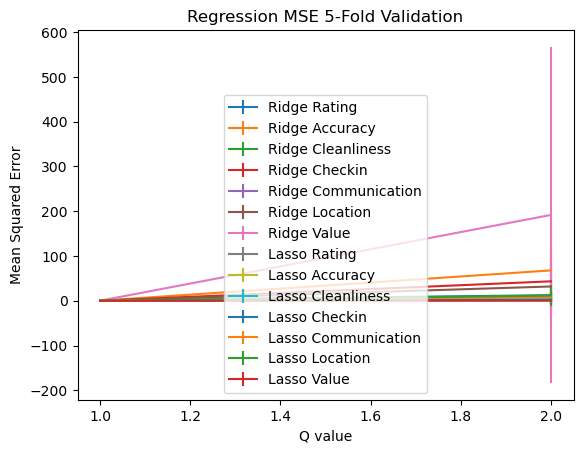

In [48]:
MeanSquareErrorPlotAlt("Regression MSE 5-Fold Validation", "Q value", Qs, MSEList, STDList, LabelList)

In [88]:
idealQ = 1
MSEListC = []
STDListC = []
LabelListC = []

ModelsCV = []
ModelTypes = ["Lasso", "Ridge"]
Cs = [0.001,0.01,0.1,1,10,100, 1000]
for mType in ModelTypes:
    for datasetKey in datasets:
        dataset = datasets[datasetKey]
        mse = []
        std = []
        hyperparameterLabel = "C"
        hyperparameterList = Cs
        for c in Cs:
            print(mType, "C =", c)
            m = MLModel()
            x = dataset.trainxPolys[idealQ]
            y = dataset.trainY
            currMSE, currSTD = m.KFoldsValidation(mType,x,y,c)
            mse.append(currMSE)
            std.append(currSTD)
            ModelsCV.append(m)
        MSEListC.append(mse)
        STDListC.append(std)
        LabelListC.append(mType + " " + datasetKey )

Lasso C = 0.001
Lasso C = 0.01
Lasso C = 0.1
Lasso C = 1
Lasso C = 10
Lasso C = 100


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.506e+01, tolerance: 2.841e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.240e+02, tolerance: 2.654e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 1000


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.135e+02, tolerance: 2.841e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.126e+02, tolerance: 2.654e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 0.001
Lasso C = 0.01
Lasso C = 0.1
Lasso C = 1
Lasso C = 10


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+01, tolerance: 7.496e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 7.019e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 100


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e+00, tolerance: 6.952e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+01, tolerance: 7.019e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 1000


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+02, tolerance: 6.952e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e+02, tolerance: 7.019e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 0.001
Lasso C = 0.01
Lasso C = 0.1
Lasso C = 1
Lasso C = 10
Lasso C = 100


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.232e+01, tolerance: 1.137e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.198e+01, tolerance: 1.221e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 1000


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+02, tolerance: 1.221e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.878e+02, tolerance: 1.204e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 0.001
Lasso C = 0.01
Lasso C = 0.1
Lasso C = 1
Lasso C = 10


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+00, tolerance: 5.629e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e+00, tolerance: 5.472e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 100


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.669e+01, tolerance: 5.629e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e+02, tolerance: 5.472e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 1000


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+02, tolerance: 5.472e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e+02, tolerance: 5.788e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 0.001
Lasso C = 0.01
Lasso C = 0.1
Lasso C = 1
Lasso C = 10


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e+01, tolerance: 5.213e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e+00, tolerance: 4.728e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 100


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+02, tolerance: 5.213e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.264e+01, tolerance: 4.728e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 1000


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e+02, tolerance: 4.728e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+02, tolerance: 5.088e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 0.001
Lasso C = 0.01
Lasso C = 0.1
Lasso C = 1
Lasso C = 10


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+00, tolerance: 5.372e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.326e-01, tolerance: 5.436e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 100


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.683e+01, tolerance: 4.976e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.374e+01, tolerance: 5.372e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 1000


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e+02, tolerance: 5.372e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.238e+02, tolerance: 5.436e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 0.001
Lasso C = 0.01
Lasso C = 0.1
Lasso C = 1
Lasso C = 10


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e+00, tolerance: 8.899e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.416e-01, tolerance: 8.367e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 100


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.923e+01, tolerance: 8.899e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.864e+01, tolerance: 8.367e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Lasso C = 1000


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.683e+02, tolerance: 8.367e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.238e+02, tolerance: 8.617e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000
Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000
Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000
Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000
Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000
Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000
Ridge C = 0.001
Ridge C = 0.01
Ridge C = 0.1
Ridge C = 1
Ridge C = 10
Ridge C = 100
Ridge C = 1000


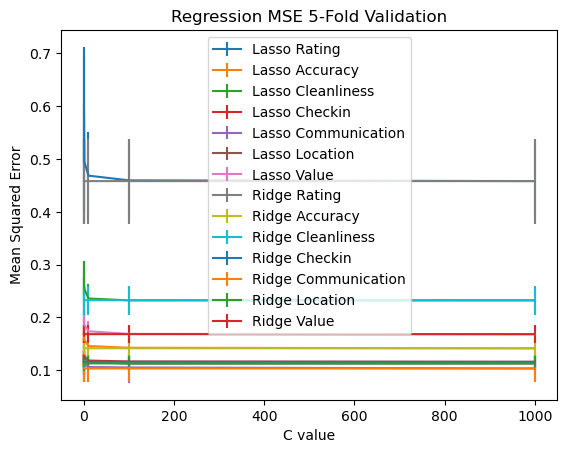

In [89]:
MeanSquareErrorPlotAlt("Regression MSE 5-Fold Validation", "C value", Cs, MSEListC, STDListC, LabelListC)

In [98]:
print(Cs)
for i,x in enumerate(MSEListC):
    cs = ""
    for element in x:
        cs += str(round(element,4)) + " & "
    cs = cs.strip(" & ")
    
    print(LabelListC[i].split(" ")[0],"&",LabelListC[i].split(" ")[1], "&", cs,"\\cr")

[0.001, 0.01, 0.1, 1, 10, 100, 1000]
Lasso & Rating & 0.6032 & 0.6005 & 0.5911 & 0.4949 & 0.4684 & 0.4595 & 0.4581 \cr
Lasso & Accuracy & 0.1619 & 0.1619 & 0.1588 & 0.1577 & 0.1458 & 0.1426 & 0.1415 \cr
Lasso & Cleanliness & 0.273 & 0.273 & 0.2634 & 0.2537 & 0.2359 & 0.2324 & 0.2323 \cr
Lasso & Checkin & 0.1278 & 0.1278 & 0.1252 & 0.1245 & 0.1184 & 0.1167 & 0.116 \cr
Lasso & Communication & 0.1149 & 0.1149 & 0.1095 & 0.1112 & 0.1062 & 0.1053 & 0.1035 \cr
Lasso & Location & 0.1215 & 0.1215 & 0.1207 & 0.1272 & 0.1155 & 0.1126 & 0.1129 \cr
Lasso & Value & 0.1965 & 0.1965 & 0.1928 & 0.1863 & 0.1737 & 0.1689 & 0.1681 \cr
Ridge & Rating & 0.4585 & 0.4575 & 0.4579 & 0.4581 & 0.4581 & 0.4581 & 0.4581 \cr
Ridge & Accuracy & 0.1421 & 0.1416 & 0.1416 & 0.1416 & 0.1416 & 0.1416 & 0.1416 \cr
Ridge & Cleanliness & 0.2324 & 0.2325 & 0.2326 & 0.2326 & 0.2326 & 0.2326 & 0.2326 \cr
Ridge & Checkin & 0.1162 & 0.116 & 0.116 & 0.116 & 0.116 & 0.1159 & 0.1159 \cr
Ridge & Communication & 0.1041 & 0.1034 & 0.

In [102]:
idealCLasso = 10
idealCRidge = 1
idealQ = 1
LassoFinalModels= {}
RidgeFinalModels = {}
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
for datasetKey in datasets:
    dataset = datasets[datasetKey]
for datasetKey in datasets:
    dataset = datasets[datasetKey]
    x = dataset.trainxPolys[idealQ]
    y = dataset.trainY
    
    Lasso = MLModel()
    Lasso.TrainModel("Lasso", x,y, c = idealCLasso)
    LassoFinalModels[datasetKey] = Lasso
    print("Lasso & " + datasetKey , "&", str(round(Lasso.Predict(dataset.validatexPolys[idealQ], dataset.validateY),4)), "\\cr")
    
    
    Ridge = MLModel()
    Ridge.TrainModel("Ridge", x,y, c = idealCRidge)
    RidgeFinalModels[datasetKey] = Ridge
    print( "Ridge & " + datasetKey , "&", str(round(Ridge.Predict(dataset.validatexPolys[idealQ], dataset.validateY),4)), "\\cr")
    
    
    dummy = DummyRegressor(strategy="mean").fit(dataset.trainX, dataset.trainY)
    dummyPred = dummy.predict(dataset.validateX)
    print("Average (Dummy) & "+ datasetKey, "&", str(round(mean_squared_error(dataset.validateY,dummyPred),4)), "\\cr")
    print("\\\\hline")

Fitting Lasso
Lasso & Rating & 0.4057 \cr
Fitting Ridge
Ridge & Rating & 0.4052 \cr
Average (Dummy) & Rating & 0.5259 \cr
\\hline
Fitting Lasso


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e-01, tolerance: 8.862e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.888e+00, tolerance: 6.990e-02
  model = cd_fast.enet_coordinate_descent(


Lasso & Accuracy & 0.1573 \cr
Fitting Ridge
Ridge & Accuracy & 0.1565 \cr
Average (Dummy) & Accuracy & 0.1685 \cr
\\hline
Fitting Lasso
Lasso & Cleanliness & 0.297 \cr
Fitting Ridge
Ridge & Cleanliness & 0.2939 \cr
Average (Dummy) & Cleanliness & 0.3517 \cr
\\hline
Fitting Lasso
Lasso & Checkin & 0.1547 \cr
Fitting Ridge
Ridge & Checkin & 0.1493 \cr
Average (Dummy) & Checkin & 0.1687 \cr
\\hline
Fitting Lasso


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.416e+00, tolerance: 6.287e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.033e-01, tolerance: 6.651e-02
  model = cd_fast.enet_coordinate_descent(


Lasso & Communication & 0.1174 \cr
Fitting Ridge
Ridge & Communication & 0.1143 \cr
Average (Dummy) & Communication & 0.136 \cr
\\hline
Fitting Lasso
Lasso & Location & 0.1346 \cr
Fitting Ridge
Ridge & Location & 0.1289 \cr
Average (Dummy) & Location & 0.1491 \cr
\\hline
Fitting Lasso
Lasso & Value & 0.1446 \cr
Fitting Ridge
Ridge & Value & 0.1406 \cr
Average (Dummy) & Value & 0.1834 \cr
\\hline


C:\Users\Matthew Radtke\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.075e-01
  model = cd_fast.enet_coordinate_descent(


In [125]:
for key in LassoFinalModels:
    model = LassoFinalModels[key]
#     datasets[key].ColumnNames
    print(key)
    dataset = datasets[key]
#     names.insert(0,"1")
#     print(len(names),names)
#     model.PrintWeights(names)
    pairs = list(zip(model.thetas[1:], dataset.polynomialFeatureNames[idealQ]))
    pairs.sort(key=lambda a: a[0])
    for pair in pairs:
        print(str(round(pair[0],6)), pair[1])
    print("____")

Rating
-0.064725 years_since_last_review
-0.000428 accommodates
-0.000237 availability_60
-0.000227 number_of_reviews_ltm
-0.000197 review_sentiment
-0.000185 availability_365
-0.000149 maximum_maximum_nights
-0.000138 host_listings_count
-0.000102 host_total_listings_count
-6.7e-05 maximum_nights
-4e-06 price
0.0 1
-0.0 name_sentiment
0.0 neighborhood_overview_sentiment
-0.0 host_duration_years
0.0 host_about_sentiment
0.0 host_response_rate
0.0 host_acceptance_rate
0.0 host_is_superhost
0.0 host_phone_verified
0.0 host_email_verified
-0.0 host_work_email_verified
0.0 host_has_profile_pic
0.0 host_identity_verified
0.0 bathrooms
-0.0 bedrooms
-0.0 beds
0.0 minimum_nights
0.0 minimum_minimum_nights
0.0 minimum_nights_avg_ntm
0.0 has_availability
-0.0 availability_30
-0.0 availability_90
0.0 number_of_reviews_l30d
-0.0 years_since_first_review
-0.0 instant_bookable
0.0 calculated_host_listings_count
-0.0 calculated_host_listings_count_entire_homes
-0.0 calculated_host_listings_count_sha

In [139]:
for key in RidgeFinalModels:
    model = RidgeFinalModels[key]
#     datasets[key].ColumnNames
    print(key,"& _ \\cr")
    dataset = datasets[key]
#     names.insert(0,"1")
#     print(len(names),names)
#     model.PrintWeights(names)
    pairs = list(zip(model.thetas[1:], dataset.polynomialFeatureNames[idealQ]))
    pairs.sort(key=lambda a: a[0])
    
    length = len(pairs)
    cutoff = 3
    for i,pair in enumerate(pairs):
        if i < 3 or length - i <= 3:
            print(pair[1], "&",str(round(pair[0],6)), "\\cr")
    print("\\hline")

Rating & _ \cr
years_since_last_review & -0.093564 \cr
host_acceptance_rate & -0.059101 \cr
host_response_rate & -0.036529 \cr
has_availability & 0.299279 \cr
host_phone_verified & 0.356342 \cr
bathrooms & 2.490918 \cr
\hline
Accuracy & _ \cr
bathrooms & -0.195457 \cr
host_acceptance_rate & -0.072593 \cr
has_availability & -0.060221 \cr
bedrooms & 0.018351 \cr
review_sentiment_average & 0.029687 \cr
host_is_superhost & 0.036414 \cr
\hline
Cleanliness & _ \cr
host_phone_verified & -0.124327 \cr
host_acceptance_rate & -0.068584 \cr
bathrooms & -0.067051 \cr
host_email_verified & 0.036532 \cr
review_sentiment_average & 0.03965 \cr
host_is_superhost & 0.052985 \cr
\hline
Checkin & _ \cr
bathrooms & -0.05681 \cr
host_acceptance_rate & -0.033792 \cr
host_has_profile_pic & -0.033017 \cr
bedrooms & 0.01419 \cr
review_sentiment_average & 0.021248 \cr
host_is_superhost & 0.033448 \cr
\hline
Communication & _ \cr
bathrooms & -0.157551 \cr
host_acceptance_rate & -0.067296 \cr
host_has_profile_pic 